This is an example of how the package "continuum" can be used to create a grid classification using in The degree of urbanisation level 1, from "A recommendation on the method to delineate cities, urban and rural areas for international statistical comparisons"

The data can be download from https://landscan.ornl.gov/ or https://ghsl.jrc.ec.europa.eu/datasets.php#inline-nav-ghs_pop2022

In [74]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import rasterstats

import contextily as ctx

from shapely.geometry import box
from pyproj import CRS

import sys
sys.path.append(r"C:\\Users\\Guillermo\\Desktop\\Python\\01. Continuo urbano-rural")
import continuum

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

In [80]:
path=r'C:\Users\Guillermo\Desktop\Python\01. Continuo urbano-rural\01. Dataset'

##límites departamentales
lim_as=gpd.read_file(path+"\\Centro y Sudamerica.zip")
lim_as=lim_as.to_crs(3857)

In [39]:
def box_32718(box_coords):
    bb=box(box_coords[0],box_coords[1],box_coords[2],box_coords[3])
    
    box_0=gpd.GeoDataFrame()
    box_0['geometry']=None
    box_0.at[0,'geometry']=bb
    
    box_0.crs = CRS.from_epsg(4326)
    return box_0

coor=[-80.60,-3.72,-79.88,-3.20]
area1=box_32718(coor)

##cortamos el raster 
with rxr.open_rasterio(path+"\\landscan-global-2017.tif", masked=True) as des_pop:
    ## using rasterio function clip and the polygons geometry, we create a new raster for Cajamarca Region
    clipped = des_pop.rio.clip(area1.geometry, area1.crs, drop=True, from_disk=True)
    ## save the clipped raster inside the data base folder in the local machine
    clipped.rio.to_raster(path+"\\north_border_clip.tif")

#### Calculamos los polígonos de densidad

In [141]:
pop_density=(path+"\\north_border_clip.tif")
band_1, aff_1=continuum.open_raster_rio(pop_density)

## Setting the values for each density's cluster
density_values=[1500, 300, 50]
population_values=[50000, 5000, 0]

## Calculate the high, medium and low density's cluster
high=(continuum.create_continuum(density_values[0], band=band_1, affine=aff_1, no_holes=True,crs_EPSG=4326, pixel_con=8).
      pipe(continuum.add_pop_sum,pop_density,population_values[0]))
medium=(continuum.create_continuum(density_values[1],band=band_1, affine=aff_1, no_holes=True,crs_EPSG=4326, pixel_con=8).
       pipe(continuum.add_pop_sum,pop_density,population_values[1]))
low=(continuum.create_continuum(density_values[2], band=band_1, affine=aff_1, crs_EPSG=4326).
    pipe(continuum.add_pop_sum,pop_density,population_values[2]))

In [142]:
## Create a new id
def new_id(gdf_d,var):
    gdf_f=(gdf_d.
           assign(id_n=gdf_d.
           sort_values(var,ascending=False).
           reset_index(drop=True).
           index+1))
    return gdf_f

high=new_id(high,"pop_t")
medium=new_id(medium,"pop_t")
low=new_id(low,"pop_t")

#### Calculamos los valores de la tipología

In [143]:
np_f=continuum.spatial_tipology(high, medium, low)

high=high.merge(np_f[np_f.density=="high"], on='id_n', validate='1:1')
medium=medium.merge(np_f[np_f.density=="medium"], on='id_n', validate='1:1')
low=low.merge(np_f[np_f.density=="low"], on='id_n', validate='1:1')

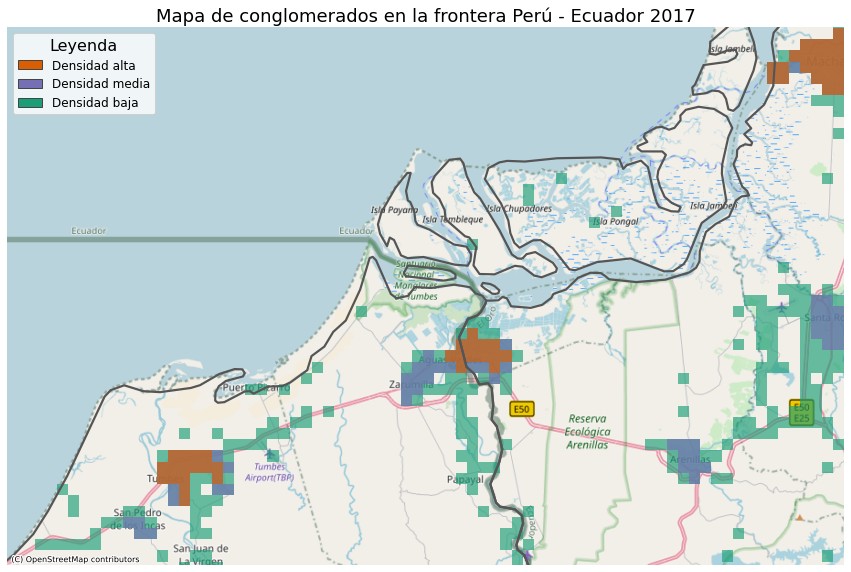

In [152]:
# Control figure size in here

labels=["Densidad alta", "Densidad media", "Densidad baja" ] ## ciudades
colors=['#d95f02','#7570b3','#1b9e77']
fig, ax = plt.subplots(figsize=(15,12))
# Plot the data
low.to_crs(3857).plot(ax=ax, color=colors[2],alpha=0.65)
medium.to_crs(3857).plot(ax=ax, color=colors[1],alpha=0.65)
high.to_crs(3857).plot(ax=ax, color=colors[0],alpha=0.65)
lim_as.clip(area1.to_crs(3857)).plot(ax=ax,facecolor='none', linewidth=2.2, edgecolor='#555555')

legend_e = [Patch(facecolor=colors[0], edgecolor='#454545', label=labels[0]),
            Patch(facecolor=colors[1], edgecolor='#454545', label=labels[1]),
            Patch(facecolor=colors[2], edgecolor='#454545', label=labels[2])]
ax.legend(handles=legend_e, prop={'size': 12}, title="Leyenda", title_fontsize=16, loc='upper left')

ax.set_axis_off()
# Add basemap 
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.DE)

# Crop the figure

ax.set_xlim(-8970000, -8900000)
ax.set_ylim(-405000, -360000)

ax.set_title("Mapa de conglomerados en la frontera Perú - Ecuador 2017",
                 fontsize=18)
plt.savefig(r"C:\Users\Guillermo\Desktop/Python\01. Continuo urbano-rural\\03. Images\\Cities_b.jpg",dpi=300,bbox_inches='tight')

In [113]:
dir(ctx.providers)

['AzureMaps',
 'BasemapAT',
 'CartoDB',
 'CyclOSM',
 'Esri',
 'FreeMapSK',
 'Gaode',
 'GeoportailFrance',
 'HERE',
 'HEREv3',
 'HikeBike',
 'Hydda',
 'Jawg',
 'JusticeMap',
 'MapBox',
 'MapTiler',
 'MtbMap',
 'NASAGIBS',
 'NLS',
 'OneMapSG',
 'OpenAIP',
 'OpenFireMap',
 'OpenPtMap',
 'OpenRailwayMap',
 'OpenSeaMap',
 'OpenSnowMap',
 'OpenStreetMap',
 'OpenTopoMap',
 'OpenWeatherMap',
 'SafeCast',
 'Stadia',
 'Stamen',
 'Strava',
 'Thunderforest',
 'TomTom',
 'USGS',
 'WaymarkedTrails',
 'nlmaps']

In [120]:
ctx.providers.Esri.keys()

dict_keys(['WorldStreetMap', 'DeLorme', 'WorldTopoMap', 'WorldImagery', 'WorldTerrain', 'WorldShadedRelief', 'WorldPhysical', 'OceanBasemap', 'NatGeoWorldMap', 'WorldGrayCanvas'])